In [2]:
%matplotlib inline
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

df_train = pd.read_csv("train.csv", parse_dates=['datetime'])
df_test = pd.read_csv("test.csv", parse_dates=['datetime'])
df_raw = pd.read_csv("train.csv", parse_dates=['datetime'])
df_raw1 = df_raw[['temp', 'atemp', 'humidity', 'windspeed', 'count']]

def EDA_data(df):
    
    df['month'] = df['datetime'].dt.month
    df['hour'] = df['datetime'].dt.hour
    df['year'] = df['datetime'].dt.year
    df['date_delta'] = (df['datetime'] - df['datetime'].min())\
    / np.timedelta64(1,'D')
    df['day'] = df['datetime'].dt.dayofweek
    df['weekend'] = df['day'].map(lambda x: 1 if x >= 5 else 0)
    
    # windspeed 전처리
    df["before-windspeed"] = df["windspeed"].shift(+1) #1시간전 바람속도 (shift로 한칸 내림)
    df["after-windspeed"]= df["windspeed"].shift(-1) # 1시간후 바람속도 (shift로 한칸 올림)
    df['before-windspeed'] = df['before-windspeed'].fillna(0) # 내리면서 NaN값 생긴것 가장 근처 값으로 처리
    df['after-windspeed'] = df['after-windspeed'].fillna(df.loc[len(df)-1]['windspeed']) #마찬가지
    df['middle-windspeed']= (df['before-windspeed'] + df['after-windspeed']) / 2 # 중간 값
    df.loc[df["windspeed"] == 0, "windspeed"] = df.loc[df["windspeed"] == 0,"middle-windspeed"] #windspeed가 0인 row에 middle-windspeed를넣는다.
    df.drop('before-windspeed', axis=1, inplace=True)
    df.drop('after-windspeed', axis=1, inplace=True)
    df.drop('middle-windspeed', axis=1, inplace=True)
    
    def fill_wind(df):
        cond1 = df['windspeed'] == 0
        WinZeroDate = df[cond1]['datetime'].unique()
        i = 0
        while i < len(WinZeroDate):
            cond2 = df['datetime'] == WinZeroDate[i]
            mean = df[cond2]['windspeed'].mean()
            df.loc[cond1&cond2, 'windspeed'] = mean
            i += 1
        return df['windspeed']
    
    df['windspeed'] = fill_wind(df)
    
    # humidity
    df[df['humidity'] == 0]
    df['humidity'] = df['humidity'].apply(lambda x: 98.75 if x == 0 else x)
    
    
    # cat for humidity
    def new_humidity(x, y):
        if x == 1:
            if y == 1:
                return 1
            else:
                return 2
        elif x == 2:
            if y == 1:
                return 3
            else:
                return 4
        elif x == 3:
            if y == 1:
                return 5
            else:
                return 6
        elif x == 4:
            if y == 1:
                return 7
            else:
                return 8
    df['new_humidity'] = df.apply(lambda x: new_humidity(x['season'], x['weather']), axis=1)
    df['new_humidity'] = df['new_humidity'].astype('category')
    
    # adjusted_atemp: atemp 이상치 변환
    def change_2(df):
        if df['atemp'] == 12.12:
            return 13.12 + 0.6215*float(df['temp']) - 11.37*(float(df["windspeed"])**0.16) + 0.3965*float(df["temp"])*(float(df["windspeed"])**0.16)
        else:
            return df['atemp']
    
    df['adjusted_atemp'] = df.apply(lambda df: change_2(df),axis= 1)

    # perfect atemp: 체감온도 공식 이용
    def change_3(df):
        return 13.12 + 0.6215*float(df['temp']) - 11.37*(float(df["windspeed"])**0.16) + 0.3965*float(df["temp"])*(float(df["windspeed"])**0.16)
    df['perfect_atemp'] = df.apply(lambda df: change_3(df), axis= 1)
    
   
    # 상호작용 변수
    df['weekend_hour'] = df['weekend'].astype('str') + '_' + df['hour'].astype('str')
    
#     df['we_mo'] = df['weekend'].astype('str') + '_' + df['hour'].astype('str')

    
    # weather
    df['weather'] = df['weather'].apply(lambda x: 3 if x == 4 else x)
    
    return df


# OLS 함수
def OLS_test(df, f):
    result = sm.OLS.from_formula(f, df).fit()
    return result
    
df_train = EDA_data(df_train)
df_test = EDA_data(df_test)

df_train['log'] = np.log(df_train['count']+3)


예시)

In [130]:
import statsmodels.api as sm
data = sm.datasets.scotland.load()
data.exog = sm.add_constant(data.exog)

gamma_model = sm.GLM(data.endog+1, data.exog,\
                     family=sm.families.Gamma())
gamma_result = gamma_model.fit()
gamma_result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            182.0078 
Link Function:      inverse_power    BIC:            -83.0932 
Dependent Variable: y                Log-Likelihood: -83.004  
Date:               2018-11-29 19:45 LL-Null:        -145.63  
No. Observations:   32               Deviance:       0.084492 
Df Model:           7                Pearson chi2:   0.0832   
Df Residuals:       24               Scale:          0.0034663
Method:             IRLS                                      
---------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
---------------------------------------------------------------
const      -0.0167    0.0111  -1.5059  0.1321  -0.0385   0.0050
x1          0.0000    0.0000   3.0443  0.0023   0.0000   0.0001
x2          0.0020    0.0005   3.8088  0.0001   0.0010   0.0030
x3         -0.0001    0.0000  -2.6528  0.0080  -0.0001  -0.0000
x4          0.0001    0.0000   2.7551  0.0059   0.0000   0.0002
x5         -0.0000    0.0000  -1.1851  0.2360  -0.0000   0.0000
x6         -0.0005    0.0002  -2.1577  0.0310  -0.0010  -0.0000
x7         -0.0000    0.0000  -3.2389  0.0012  -0.0000  -0.0000
==============================================================

"""

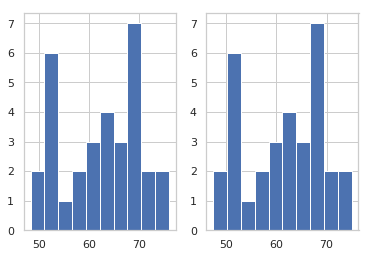

In [131]:
# 정규성
plt.subplot(121)
plt.hist(gamma_model.endog)
plt.subplot(122)
plt.hist(data.endog)
plt.show()

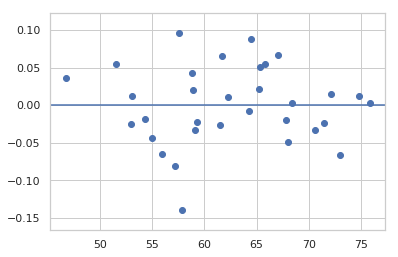

In [132]:
# y hat vs resid 
plt.scatter(gamma_result.fittedvalues, gamma_result.resid_pearson)
plt.axhline(y=0)
plt.show()

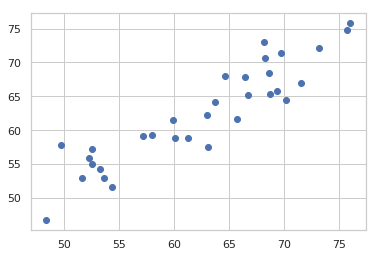

In [133]:
# fitted vs y
x = np.linspace(40, 75, 100)
plt.scatter(gamma_model.endog, gamma_result.fittedvalues)
plt.show()

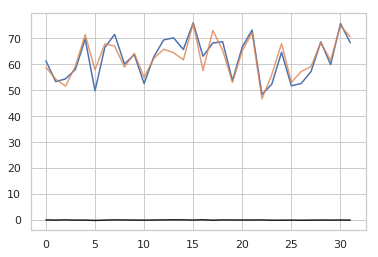

In [134]:
# y vs yhat vs resid
plt.plot(gamma_model.endog)
plt.plot(gamma_result.fittedvalues, alpha=0.8)
plt.plot(gamma_result.resid_pearson, c='k')
plt.show()

실전)

In [3]:
from patsy import dmatrix
f = 'scale(adjusted_atemp) + scale(windspeed) + scale(humidity):C(hour):C(new_humidity) + scale(date_delta) + scale(I(date_delta**2)) + scale(I(date_delta**3)) + C(weekend):C(hour) + scale(I(windspeed**2)):C(month):C(hour)-1'
df = dmatrix(f, df_train, return_type="dataframe")

In [4]:
m = sm.GLM(df_train['count'], df, family=sm.families.Poisson(sm.families.links.log))
re = m.fit()

In [5]:
re.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Generalized linear model
===================================================================================================
Model:                           GLM                         AIC:                       212544.4905
Link Function:                   log                         BIC:                       45598.0252 
Dependent Variable:              count                       Log-Likelihood:            -1.0574e+05
Date:                            2018-11-29 20:13            LL-Null:                   -9.3511e+05
No. Observations:                10886                       Deviance:                  1.4183e+05 
Df Model:                        532                         Pearson chi2:              1.38e+05   
Df Residuals:                    10353                       Scale:                     1.0000     
Method:                          IRLS                                                              
---------------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------
C(weekend)[0]:C(hour)[0]                           3.5937   0.0110  327.7943 0.0000  3.5723  3.6152
C(weekend)[1]:C(hour)[0]                           4.5293   0.0108  417.9831 0.0000  4.5080  4.5505
C(weekend)[0]:C(hour)[1]                           2.7882   0.0162  172.6105 0.0000  2.7565  2.8198
C(weekend)[1]:C(hour)[1]                           4.2533   0.0138  309.0929 0.0000  4.2263  4.2803
C(weekend)[0]:C(hour)[2]                           2.1680   0.0212  102.1998 0.0000  2.1265  2.2096
C(weekend)[1]:C(hour)[2]                           3.9903   0.0161  248.3398 0.0000  3.9588  4.0218
C(weekend)[0]:C(hour)[3]                           1.5790   0.0296   53.4125 0.0000  1.5211  1.6370
C(weekend)[1]:C(hour)[3]                           3.2462   0.0233  139.3784 0.0000  3.2006  3.2918
C(weekend)[0]:C(hour)[4]                           1.6437   0.0320   51.3470 0.0000  1.5809  1.7064
C(weekend)[1]:C(hour)[4]                           2.1530   0.0368   58.4463 0.0000  2.0808  2.2252
C(weekend)[0]:C(hour)[5]                           3.1991   0.0161  199.2815 0.0000  3.1676  3.2305
C(weekend)[1]:C(hour)[5]                           2.1903   0.0319   68.6233 0.0000  2.1278  2.2529
C(weekend)[0]:C(hour)[6]                           4.6390   0.0079  586.2993 0.0000  4.6235  4.6545
C(weekend)[1]:C(hour)[6]                           2.9414   0.0214  137.5455 0.0000  2.8995  2.9834
C(weekend)[0]:C(hour)[7]                           5.7080   0.0044 1310.2074 0.0000  5.6995  5.7165
C(weekend)[1]:C(hour)[7]                           3.7833   0.0141  269.1674 0.0000  3.7557  3.8108
C(weekend)[0]:C(hour)[8]                           6.1869   0.0030 2072.8538 0.0000  6.1811  6.1928
C(weekend)[1]:C(hour)[8]                           4.6329   0.0089  521.5699 0.0000  4.6154  4.6503
C(weekend)[0]:C(hour)[9]                           5.4657   0.0041 1342.7418 0.0000  5.4577  5.4737
C(weekend)[1]:C(hour)[9]                           5.1310   0.0069  742.1323 0.0000  5.1174  5.1445
C(weekend)[0]:C(hour)[10]                          4.8600   0.0052  927.4278 0.0000  4.8497  4.8703
C(weekend)[1]:C(hour)[10]                          5.5158   0.0060  915.2228 0.0000  5.5039  5.5276
C(weekend)[0]:C(hour)[11]                          4.9802   0.0051  983.4277 0.0000  4.9702  4.9901
C(weekend)[1]:C(hour)[11]                          5.6928   0.0057 1006.5699 0.0000  5.6817  5.7039
C(weekend)[0]:C(hour)[12]                          5.1584   0.0047 1090.8734 0.0000  5.1491  5.1677
C(weekend)[1]:C(hour)[12]                          5.8006   0.0056 1035.8903 0.0000  5.7896  5.8116
C(weekend)[0]:C(hour)[13]                          5.1005   0.0050 1017.5970 0.0000 

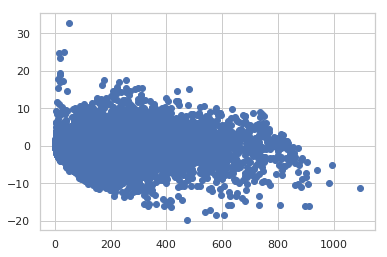

In [7]:
# resid vs y hat
plt.scatter(re.fittedvalues, re.resid_pearson)
plt.show()

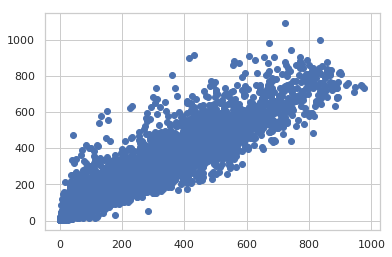

In [8]:
# y vs yhat
plt.scatter(m.endog, re.fittedvalues)
plt.show()

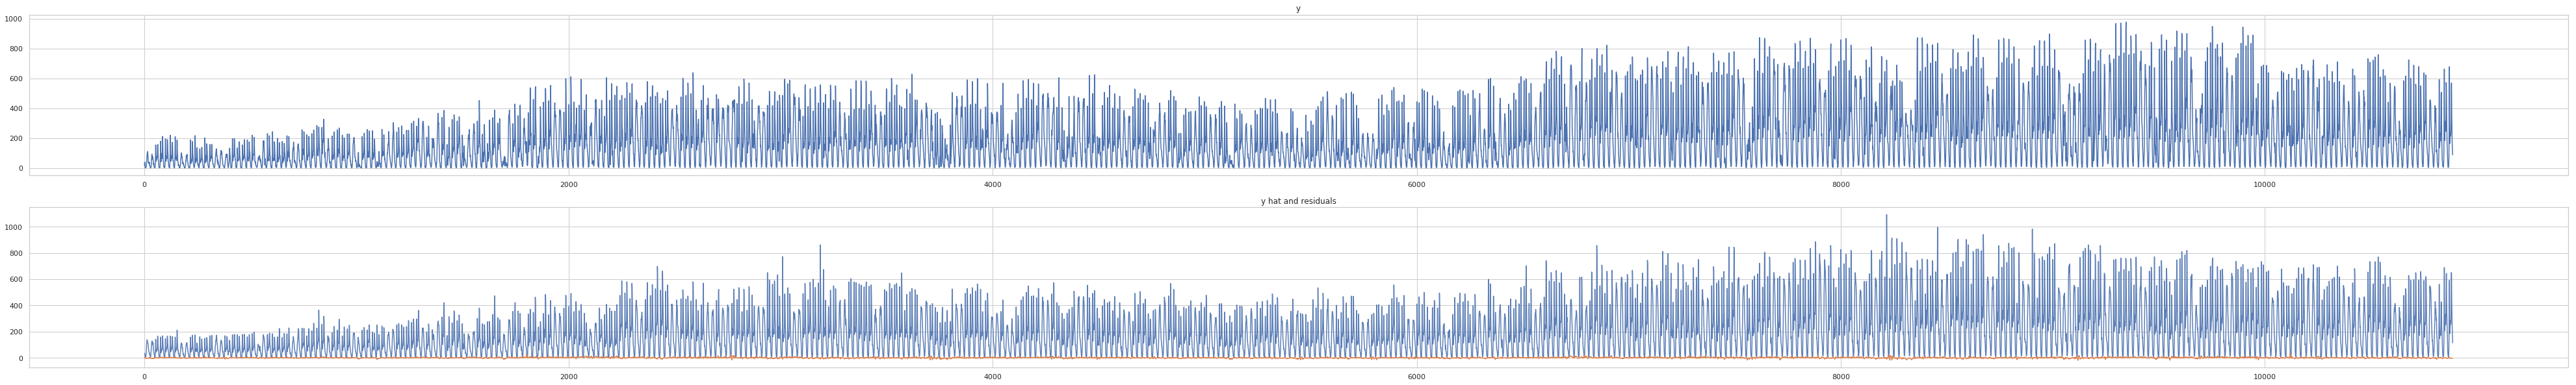

In [13]:
# 시각화
plt.figure(figsize=(70, 10))

plt.subplot(211)
plt.plot(m.endog)
plt.title('y')

plt.subplot(212)
plt.plot(re.fittedvalues, alpha=0.9)
plt.plot(re.resid_pearson)
plt.title('y hat and residuals')

plt.show()